In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import norse.torch as norse
from norse.torch import PoissonEncoder

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# MNIST LOADER
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)

0


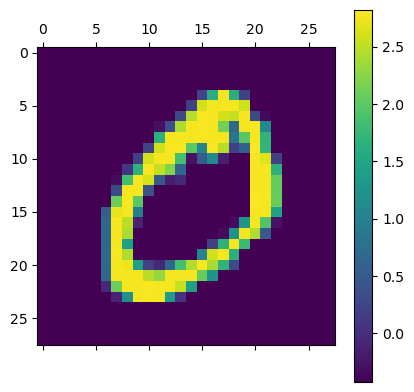

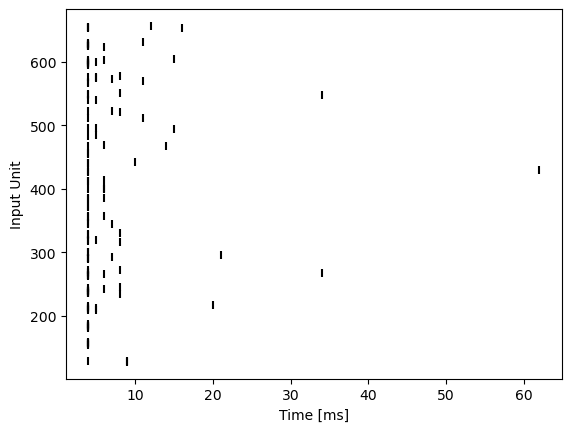

In [3]:
from norse.torch.functional.decode import sum_decode
from norse.torch.module.encode import SpikeLatencyLIFEncoder

# example image
img, label = train_data[1]

plt.matshow(img[0])
plt.colorbar()
print(label)

# encoding scheme
T = 128
#poisson_encoder = PoissonEncoder(T,f_max=20)
#spike_train_img = poisson_encoder(img).reshape(T,28*28).to_sparse().coalesce()
spike_latency_encoder = SpikeLatencyLIFEncoder(T)
spike_train_img = spike_latency_encoder(img).reshape(T,28*28).to_sparse().coalesce()
t = spike_train_img.indices()[0]
n = spike_train_img.indices()[1]
plt.figure()
plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

def decode(x):
    #x = torch.mean(x, dim=0)
    x= x[-1]
    #print("x.shape")
    #print(x.shape)
    #print("value.shape")
    #print(value.shape)
    #x = sum_decode(x)
    #print(x.shape)
    return x

In [4]:
from norse.torch.module.lif import LIFCell
from norse.torch.functional import LIFParameters
from norse.torch.module.leaky_integrator import LICell, LIParameters
class AutoEncoder(nn.Module):
    def __init__(self,num_channels=1,feature_size=28,method="super",alpha=100,dt=0.001):
        super(AutoEncoder,self).__init__()
        
        self.feature_size = feature_size
        
        # Encoder
        self.encoder1 = norse.SequentialState(
            nn.Conv2d(in_channels=num_channels,out_channels=4,kernel_size=4,stride=2,padding=1), # 8x14x14
            LIFCell(p=LIFParameters(tau_syn_inv=300, tau_mem_inv=100, method=method, alpha=alpha))
        )
        self.encoder2 = norse.SequentialState(
            nn.Conv2d(in_channels=4,out_channels=4,kernel_size=4,stride=2,padding=1), # 8x7x7
            LIFCell(p=LIFParameters(tau_syn_inv=300, tau_mem_inv=100, method=method, alpha=alpha))
        )
        
        # Bottleneck
        self.bottleneck1 = norse.SequentialState(
            nn.Flatten(),
            nn.Linear(4*7*7, 3),
            LIFCell(p=LIFParameters(tau_syn_inv=300, tau_mem_inv=100, method=method, alpha=alpha))
        )
        self.bottleneck2 = norse.SequentialState(
            nn.Linear(3,4*7*7),
            LIFCell(p=LIFParameters(tau_syn_inv=300, tau_mem_inv=100, method=method, alpha=alpha))
        )
        
        # Decoder
        self.decoder1 = norse.SequentialState(
            nn.Unflatten(1,(4,7,7)), # 8x7x7
            nn.Upsample(size=(14,14),mode='bilinear',align_corners=True),
            nn.Conv2d(in_channels=4,out_channels=4,kernel_size=3,stride=1,padding=1), # 8x14x14
            LIFCell(p=LIFParameters(tau_syn_inv=300, tau_mem_inv=100, method=method, alpha=alpha))
        )
        self.decoder2 = norse.SequentialState(
            nn.Upsample(size=(28,28),mode='bilinear',align_corners=True), # 8x28x28
            nn.Conv2d(in_channels=4,out_channels=num_channels,kernel_size=3,stride=1,padding=1), # 1x28x28
            LICell(p=LIParameters(tau_syn_inv=300, tau_mem_inv=100),dt=dt)
            #LIFCell(p=LIFParameters(tau_syn_inv=900, tau_mem_inv=600, method=method, alpha=alpha))
        )
        
    def forward(self,x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        num_channels = x.shape[2]
        height = x.shape[3]
        
        # specify the initial states
        s0=s1=s2=s3=s4=so=None
        
        voltages = torch.zeros(seq_length,batch_size,num_channels,height,height,device=x.device,dtype=x.dtype)
        
        for ts in range(seq_length):
            z,s0 = self.encoder1(x[ts,:],s0)
            z,s1 = self.encoder2(z,s1)
            z,s2 = self.bottleneck1(z,s2)
            z,s3 = self.bottleneck2(z,s3)
            z,s4 = self.decoder1(z,s4)
            vo,so = self.decoder2(z,so)
            
            voltages[ts,:] += torch.Tensor(vo)
        
        return voltages

In [5]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        x = self.decoder(x)
        return x

In [6]:
from tqdm.notebook import tqdm, trange

EPOCHS = 2  # Increase this number for better performance


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        target = data ## autoencoding task
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [7]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

model = Model(
    encoder=spike_latency_encoder,
    snn=AutoEncoder(1,28,"super",100,0.001),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

cuda


Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): AutoEncoder(
    (encoder1): SequentialState(
      (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(300), tau_mem_inv=tensor(100), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100)), dt=0.001)
    )
    (encoder2): SequentialState(
      (0): Conv2d(4, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(300), tau_mem_inv=tensor(100), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100)), dt=0.001)
    )
    (bottleneck1): SequentialState(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=196, out_features=3, bias=True)
      (2): LIFCell(p=LIFParameters(tau_syn_inv=tensor(300), tau_mem_inv=tensor(100), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100)), dt=0.001)
  

In [ ]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(
        model, DEVICE, test_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    #test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    #test_losses.append(test_loss)
    #accuracies.append(accuracy)

#print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# Test function
def test_ae(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            
            # Forward pass
            recon_batch = model(inputs)

            # Visualize original and reconstructed images
            visualize_images(inputs, recon_batch, 5)
            
# Visualization function
def visualize_images(original, reconstructed, num_images=5):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    print(np.max(reconstructed))
    #print(reconstructed.shape)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images
        
        reconstructed[i] = (reconstructed[i] - np.min(reconstructed[i])) / (np.max(reconstructed[i]) - np.min(reconstructed[i]))
        
        axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.show()

In [ ]:
#test_ae(model,train_loader)
test_ae(model,test_loader)